In [4]:
from tqdm import tqdm
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl
from Levenshtein import distance as levenstein

import mnist_converter
import image_shower
import context_transform
import image_transformations

np.warnings.filterwarnings('ignore')

%matplotlib inline

ImportError: No module named 'mnist_converter'

Зададим конфиг для изображений

In [2]:
path_mnist = 'data/MNIST/'
conf_test_mnist = {
    'imgf': path_mnist+'t10k-images.idx3-ubyte',
    'labelf': path_mnist+'t10k-labels.idx1-ubyte',
    'n': 10000,
    'outf': path_mnist+'mnist_test.csv',
    'size': (28, 28)
}
conf_train_mnist = {
    'imgf': path_mnist+'train-images.idx3-ubyte',
    'labelf': path_mnist+'train-labels.idx1-ubyte',
    'n': 60000,
    'outf': path_mnist+'mnist_train.csv',
    'size': (28, 28)
}

Загрузим изображения и отобразим внутренне представление

In [3]:
df = pd.read_csv(conf_train_mnist['outf'], header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Визуализируем несколько цифр

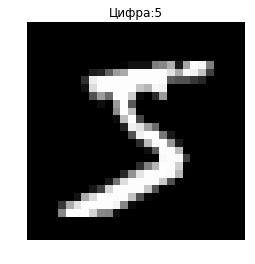

In [4]:
image_shower.show_image_data_frame(df, 0);

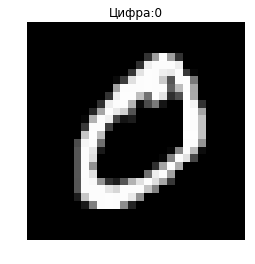

In [5]:
image_shower.show_image_data_frame(df, 1);

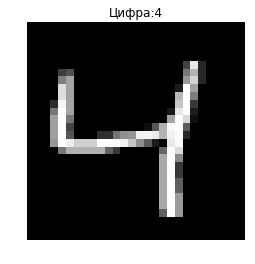

In [6]:
image_shower.show_image_data_frame(df, 2);

Наложем фильтр Собеля

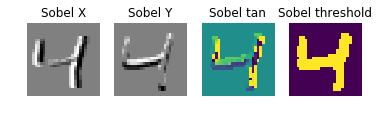

In [7]:
sobel_threshold = 0.00

label, image = image_transformations.get_image(df, 2)
sobel_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
sobel_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(sobel_x, cmap='gray')
ax1.set_title('Sobel X')
ax1.axis('off')
ax2.imshow(sobel_y, cmap='gray')
ax2.set_title('Sobel Y')
ax2.axis('off')
ax3.imshow(np.arctan2(sobel_y, sobel_x))
ax3.set_title('Sobel tan')
ax3.axis('off')
ax4.set_title('Sobel threshold')
ax4.imshow(np.abs(np.arctan2(sobel_y, sobel_x)) > sobel_threshold)
ax4.axis('off');

Выведем изображение, демонстрирующее, распределение кодов

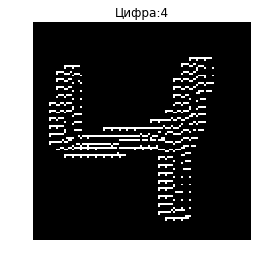

In [8]:
code_distrib = np.zeros((28*4, 28*4))
for y in range(0, 28*4, 4):
    for x in range(0, 28*4, 4):
        code_distrib[y:y+4, x:x+4] = context_transform.get_codes(image)[:, y//4, x//4].reshape((4, 4))
image_shower.show_image(code_distrib, label)

Посмотрим на распределение значений фильтра

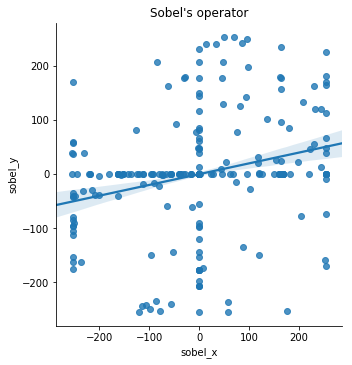

In [9]:
sns.lmplot(x='sobel_x', y='sobel_y', data=pd.DataFrame(np.transpose(np.array([sobel_x.flatten(), sobel_y.flatten()])), columns=['sobel_x', 'sobel_y']));
plt.title('Sobel\'s operator');

### Выбор контекста-победителя. Пример

Зададим начальные значения. Входное изображение; центр области, из которой требуется вырезать подизображение; размер изображения, которое будет преобразовано к другому контексту; номер контекста

In [10]:
image_number = 5
x0 = 12
y0 = 13
window_size = [4, 4]
context_number = [1, 1]

Продемонстрируем всё входное изображение

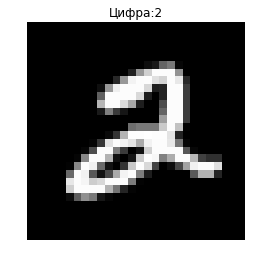

In [11]:
image_shower.show_image_data_frame(df, image_number, plt)

Получим подизображение и преобразуем его к соответсвующему контексту

In [12]:
label, image = image_transformations.get_image(df, image_number)
input_image = image[y0:y0+window_size[0], x0:x0+window_size[1]]
context_image = context_transform.get_context_image(context_number=context_number, image=image[y0:y0+window_size[0], x0:x0+window_size[1]])

Входное изображение

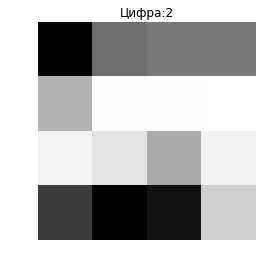

In [13]:
image_shower.show_image(input_image, label, plt)

Отобразим изображение в новом контексте

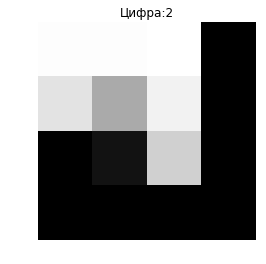

In [14]:
image_shower.show_image(context_image, label, plt)

### Выбор контекста-победителя. Построение контекста-победителя

Пусть изображение из датасета под $№\ image\_number$, находящееся в точке $(y_0, x_0)$ правым углом будет памятью. Будем брать все подизображения исходного изображения и получать его коды во всех контекстах. Для каждого такого подизображения будем находить контекст-победитель на основе сравнения кода в одном из контекстов с кодом из памяти.

Зададим начальные параметры:

In [15]:
image_number = 4
x0 = 12
y0 = 12
window_size = [4, 4]
label, image = image_transformations.get_image(df, image_number)

Покажем изображение

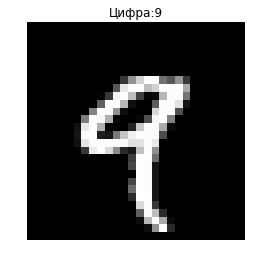

In [16]:
image_shower.show_image(image, label)

Создадим память, составленную из части этого изображения

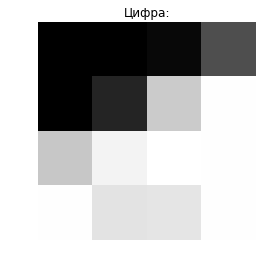

In [17]:
memory_image = image[y0:y0+window_size[0], x0:x0+window_size[1]]
memory_code = context_transform.get_codes(memory_image)
image_shower.show_image(memory_image)

Выберем подизображение, которое не пересекается с изображением из памяти

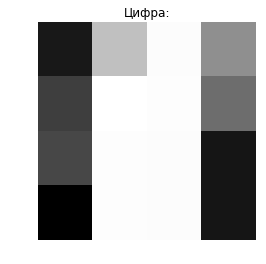

In [18]:
x_other = 13
y_other = 16
other_sub_image = image[y_other:y_other+window_size[0], x_other:x_other+window_size[1]]
image_shower.show_image(other_sub_image)

Приведём его ко всем возможным контекстам и посчитаем скалярное произведение для кодов

In [19]:
context_codes = []
map_of_distance = []
for context_y in np.arange(-window_size[0]+1, window_size[1], 1):
    context_codes.append([])
    map_of_distance.append([])
    for context_x in np.arange(-window_size[1]+1, window_size[1], 1):
        context_number = [context_y, context_x]
        context_image = context_transform.get_context_image(context_number=context_number, image=other_sub_image)
        context_code = context_transform.get_codes(context_image)
        context_codes[-1].append(context_code)
        map_of_distance[-1].append(np.dot(context_code.flatten(), memory_code.flatten()))

Выведем матрицу значений со скалярными произведениями от памяти до всех возможных контекстов и значение скалярного произведения до контекста-победителя

Значение контекста-победителя: 26


,-3,-2,-1,0,1,2,3
-3,5,8,12,12,13,10,6
-2,12,16,21,26,20,15,11
-1,14,17,19,22,13,6,6
0,14,26,20,12,6,1,1
1,7,14,12,6,0,0,0
2,5,11,11,5,0,0,0
3,0,5,10,5,0,0,0


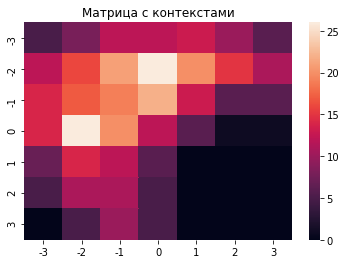

In [20]:
map_of_distance = pd.DataFrame(map_of_distance)
map_of_distance = map_of_distance.set_index(np.arange(-window_size[0]+1, window_size[1], 1))
map_of_distance.columns = np.arange(-window_size[0]+1, window_size[1], 1)
sns.heatmap(map_of_distance)
plt.title('Матрица с контекстами')
print('Значение контекста-победителя:', np.max(map_of_distance.as_matrix().flatten()))
map_of_distance

Выведем центрированное изображение ещё раз

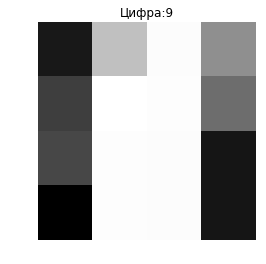

In [21]:
image_shower.show_image(other_sub_image, label=label)

Выведем все подизображения победители и подизображение из памяти

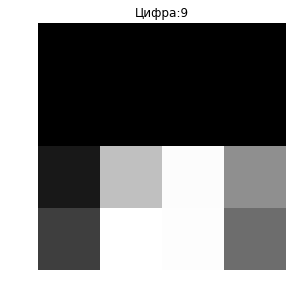

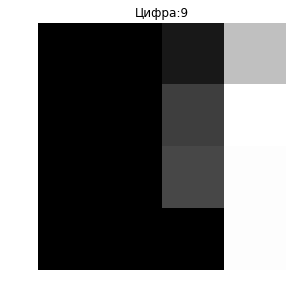

In [22]:
map_of_distance_matrix = map_of_distance.as_matrix()
context_y, context_x = np.where(map_of_distance_matrix == np.max(map_of_distance_matrix.flatten()))
context_y, context_x = context_y - (window_size[0] - 1), context_x - (window_size[1] - 1)
for context_num in range(len(context_x)):
    plt.figure(figsize=(5,5*len(context_x)))
    plt.subplot(len(context_x), 1, context_num+1);
    image_shower.show_image(context_transform.get_context_image(context_number=[context_y[context_num], context_x[context_num]], image=other_sub_image),
              label=label)

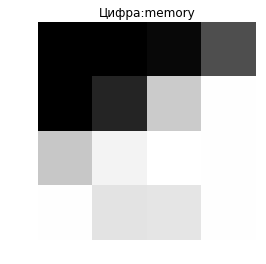

In [23]:
image_shower.show_image(memory_image, 'memory')

Как видим, подизображения в соответсвующих контекстах близки к подизображению из памяти. Путём наложения контекстных подизображений на изображение из памяти, можно увидеть, что они обладают большой площадью пересечения.